# Prepare notebook

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import pickle
import pyLDAvis
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import string
from wordcloud import WordCloud
from plotting_utilities import *

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/acraig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/acraig/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/acraig/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Import data

In [3]:
books = pd.read_pickle('20191128_goodreads_book_data.pkl')

In [4]:
len(books)

610

In [5]:
profession_filter = re.compile(r'(?<=\ is a)[n\ ](.*?)(?=\.)')

In [6]:
books['author_profession'] = books.goodreads_author_bio.fillna('').apply(lambda s: re.search(profession_filter, s).group(1) 
                                                                         if re.search(profession_filter, s) is not None else None)

In [7]:
books.author_profession.count()

199

# Prepare textual data

In [9]:
alphanumeric_filter = re.compile('[\W_]+')
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

books['filtered_author_profession'] = books.author_profession.fillna('')\
                                    .map(lambda x: alphanumeric_filter.sub(' ', x).lower().strip())\
                                    .map(lambda text: ' '.join([wnl.lemmatize(token) for token in wpt.tokenize(text) 
                                                                 if (token not in stop_words) and 
                                                                    (nltk.pos_tag([token])[0][1] == 'NN')
                                                               ]))

<>:1: DeprecationWarning: invalid escape sequence \W
<>:1: DeprecationWarning: invalid escape sequence \W
<>:1: DeprecationWarning: invalid escape sequence \W
<ipython-input-9-46eba952986e>:1: DeprecationWarning: invalid escape sequence \W
  alphanumeric_filter = re.compile('[\W_]+')


In [11]:
books['filtered_doc_length'] = books.filtered_author_profession.map(lambda text: len(text.split(' ')))

 # Visualization

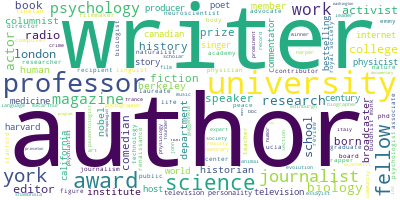

In [12]:
# Generate a word cloud based on all author_bios
wordcloud = WordCloud(background_color="white", max_words=1000)
wordcloud.generate(','.join(list(books.filtered_author_profession.drop_duplicates().values)))
wordcloud.to_image()

# Word counting methods

In [13]:
max_df=0.90
min_df=4
max_features=2000


### Bag of words

In [14]:
# Fit and transform the author_bios
word_bag_cv = CountVectorizer(ngram_range=(1,1), #max_df=max_df, min_df=min_df, 
                              #max_features=max_features,
                             stop_words=['new', 'york', 'times', 'bestselling', 
                                          'bestseller', 'award', 'winning', 'book'])
word_bag_counts = word_bag_cv.fit_transform(books.filtered_author_profession.drop_duplicates())

# Check against visualization
n = 5
counts = word_bag_counts.toarray().sum(axis = 0)
words = word_bag_cv.get_feature_names()
[words[i] for i in np.argpartition(counts, -n)[-n:]] 

['science', 'professor', 'author', 'university', 'writer']

### Bag of bigrams

In [15]:
# Fit and transform the author_bios
bigram_bag_cv = CountVectorizer(ngram_range=(2,2),  #max_df=max_df, min_df=min_df, 
                              #max_features=max_features,
                             stop_words=['new', 'york', 'times', 'bestselling', 
                                          'bestseller', 'award', 'winning', 'book'])
bigram_bag_counts = bigram_bag_cv .fit_transform(books.filtered_author_profession.drop_duplicates())

# Check against visualization
n = 5
counts = bigram_bag_counts.toarray().sum(axis = 0)
bigrams = bigram_bag_cv.get_feature_names()
[bigrams[i] for i in np.argpartition(counts, -n)[-n:]] 

['buddhist monk',
 'college london',
 'science writer',
 'professor psychology',
 'television personality']

### TF-IDF 

In [16]:
tfidf_v = TfidfVectorizer(use_idf=True,  #max_df=max_df, min_df=min_df, 
                              #max_features=max_features,
                             stop_words=['new', 'york', 'times', 'bestselling', 
                                          'bestseller', 'award', 'winning', 'book'])
tfidf_weights = tfidf_v.fit_transform(books.filtered_author_profession.drop_duplicates())

# Check against visualization
n = 10
weights = tfidf_weights.toarray().sum(axis = 0)
weighted_words = tfidf_v.get_feature_names()
[weighted_words[i] for i in np.argpartition(weights, -n)[-n:]] 

['radio',
 'psychology',
 'magazine',
 'science',
 'fellow',
 'professor',
 'writer',
 'author',
 'journalist',
 'university']

# Profession Modeling

In [17]:
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [18]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_components = 5

def print_top_words(model, feature_names, n_top_words = 10):
    for topic_idx, topic in enumerate(model.components_):
        message = " Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [19]:
# Fit the NMF model (Frobenius norm)
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_weights)
print("\nTopics in NMF model (Frobenius norm):")
print_top_words(nmf, tfidf_v.get_feature_names())


Topics in NMF model (Frobenius norm):
 Topic #0: university professor biology psychology department research history neuroscientist director fellow
 Topic #1: journalist broadcaster historian blogger lgbt glaad non fiction dc playwright
 Topic #2: author radio host science comedian actor columnist activist espionage fiction
 Topic #3: writer washington biochemist public filmmaker nature speaker teacher documentary critic
 Topic #4: magazine editor harper gq countless review science oprah discover newspaper



In [20]:
# Fit the NMF model (generalized Kullback-Leibler divergence)
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf_weights)
print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
print_top_words(nmf, tfidf_v.get_feature_names())


Topics in NMF model (generalized Kullback-Leibler divergence):
 Topic #0: professor university biology history psychology research department school human california
 Topic #1: journalist author writer historian broadcaster fiction columnist born biographer washington
 Topic #2: author activist radio buddhist century researcher canadian contributor commentator expert
 Topic #3: writer actor comedian television producer personality singer composer rapper emmy
 Topic #4: fellow science magazine editor society member institute work college phd



In [21]:
# Fit LDA model 
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(word_bag_counts)
print("\nTopics in LDA model:")
print_top_words(lda, word_bag_cv.get_feature_names())


Topics in LDA model:
 Topic #0: professor university journalist fellow science author psychology researcher macarthur theorist
 Topic #1: university professor department biology college london poet science naturalist anthropologist
 Topic #2: institute work technology century speaker historic spur account trailblazer california
 Topic #3: author professor university historian broadcaster fellow school born neuroscientist journalist
 Topic #4: writer author actor television journalist radio comedian human time renaissance



In [22]:


lda_data =  pyLDAvis.prepare(topic_term_dists = lda.components_, 
                             doc_topic_dists = lda.transform(word_bag_counts.toarray()), 
                             doc_lengths = books.drop_duplicates(subset =['filtered_author_profession']).filtered_doc_length.values,
                             vocab = word_bag_cv.get_feature_names(),
                             term_frequency = word_bag_counts.toarray().sum(axis = 0),
                             sort_topics=True)
pyLDAvis.display(lda_data)

/Users/acraig/Desktop/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Decomposition hyperparameter optimization 

In [23]:
from sklearn.metrics import log_loss, make_scorer, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans

In [24]:
def custom_scorer_highest_topic_silhouette(estimator, X):
    X = X.toarray()
    return silhouette_score(X, np.argmax(estimator.transform(X), axis =1))
  
def custom_scorer_highest_topic_calinski_harabasz(estimator, X):
    X = X.toarray()
    return calinski_harabasz_score(X, np.argmax(estimator.transform(X), axis =1))


def custom_scorer_kmeans_silhouette(estimator, X):
    X = X.toarray()
    kmeans_model = KMeans(n_clusters=estimator.n_components, random_state=1).fit(X)
    labels = kmeans_model.labels_
    return silhouette_score(X, labels)
  
def custom_scorer_kmeans_calinski_harabasz(estimator, X):
    X = X.toarray()
    kmeans_model = KMeans(n_clusters=estimator.n_components, random_state=1).fit(X)
    labels = kmeans_model.labels_
    return calinski_harabasz_score(X, labels)

def custom_scorer_log_likelihood(estimator, X):
    X = X.toarray()
    return estimator.score(X)

def custom_scorer_negative_perplexity(estimator, X):
    X = X.toarray()
    return -1*estimator.perplexity(X)

In [25]:
scoring = {'silhoutte_simple_cluster':custom_scorer_highest_topic_silhouette, 
           'silhoutte_kmeans_cluster': custom_scorer_kmeans_silhouette,
           'calinski_harabasz_simple_cluster':custom_scorer_highest_topic_calinski_harabasz, 
           'calinski_harabasz_kmeans_cluster': custom_scorer_kmeans_calinski_harabasz,
           'log_likelihood': custom_scorer_log_likelihood,
           'negative_perplexity': custom_scorer_negative_perplexity}

param_grid={'n_components': [2, 4, 6], 
                                    'learning_decay': [.5, .7, .9],
                                    'learning_offset': [20, 30, 40], 
                                    'max_iter': [50, 75, 100]}

# Handling word ending issues

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
unique_bios = books.filtered_author_profession.drop_duplicates()
unique_bios = unique_bios.reset_index()

In [28]:
all_bios = list(set(' '.join(unique_bios.filtered_author_profession).split(' ')))

In [29]:
vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (3,3))
profession_ngrams = vectorizer.fit_transform(all_bios)
#print(vectorizer.get_feature_names())

similarities = np.triu(cosine_similarity(profession_ngrams))

matches = np.where((similarities > 0.75) & (similarities < 0.9999))

d = {}

for i, m1 in enumerate(matches[0]):
    if m1 not in d.keys():
        d[m1] = [all_bios[m1], all_bios[matches[1][i]]]    
    else:
        d[m1] += [all_bios[matches[1][i]]] 
d                

{7: ['neuropsychiatrist', 'psychiatrist'],
 10: ['buddhist', 'buddhism'],
 23: ['psychiatry', 'psychiatrist'],
 27: ['princeton', 'prince'],
 33: ['journalist', 'journal', 'journalism'],
 110: ['entomology', 'entomologist'],
 111: ['sociologist', 'biologist'],
 117: ['historic', 'historian'],
 119: ['history', 'story'],
 123: ['fiction', 'nonfiction'],
 126: ['psychology', 'psychologist'],
 135: ['kenya', 'kenyan'],
 174: ['criticism', 'critic'],
 182: ['paleoanthropologist', 'anthropologist'],
 189: ['neuroscientist', 'scientist'],
 190: ['institution', 'institute'],
 199: ['researcher', 'research'],
 211: ['coeditor', 'editor'],
 238: ['philosopher', 'philosophy'],
 239: ['review', 'reviewer'],
 245: ['president', 'resident'],
 272: ['journal', 'journalism'],
 278: ['lgbt', 'lgbtq'],
 288: ['anthropology', 'anthropologist'],
 299: ['column', 'columnist'],
 307: ['revolution', 'evolution']}

In [30]:
mappings = {}

In [31]:
# sopher -> sophy
matches = [p for p in all_bios if 'sopher' in p]
print(matches)


for m in matches:
    mappings[m] = m.replace('sopher', 'sophy')

['philosopher']


In [32]:
# gist -> gy
matches = [p for p in all_bios if 'gist' in p]
print(matches)

for m in matches:
    mappings[m] = m.replace('gist', 'gy')

['sociologist', 'psychologist', 'paleoanthropologist', 'paleontologist', 'primatologist', 'biologist', 'entomologist', 'ethologist', 'anthropologist', 'egyptologist']


In [33]:
# trist -> try
matches = [p for p in all_bios if 'trist' in p]
print(matches)

for m in matches:
    mappings[m] = m.replace('trist', 'try')

['neuropsychiatrist', 'psychiatrist']


In [34]:
# scientist -> science
matches = [p for p in all_bios if 'scientist' in p]
print(matches)

for m in matches:
    mappings[m] = m.replace('scientist', 'science')

['neuroscientist', 'scientist']


In [35]:
mappings['historian'] = 'history'
mappings['buddhist'] = 'buddhism'
mappings['journalist'] = 'journalism'
mappings['architect'] = 'architecture'
mappings['conservationist'] = 'conservation'
mappings['activist'] = 'activism'

mappings['researcher'] = 'research'
mappings['reviewer'] = 'review'

mappings['physicist'] = 'physics'

mappings['economist'] = 'economics'
mappings['biochemist'] = 'biochemistry'
mappings['neuroanatomist'] ='neuroanatomy'
mappings['theorist'] = 'theory'

mappings['psychotherapist'] = 'psychotherapy'
mappings['philanthropist'] ='philanthropy'

mappings['artist'] = 'art'
mappings['naturalist'] = 'natural'

mappings['linguist'] = 'linguistics'

In [96]:
mappings

{'philosopher': 'philosophy',
 'sociologist': 'sociology',
 'psychologist': 'psychology',
 'paleoanthropologist': 'paleoanthropology',
 'paleontologist': 'paleontology',
 'primatologist': 'primatology',
 'biologist': 'biology',
 'entomologist': 'entomology',
 'ethologist': 'ethology',
 'anthropologist': 'anthropology',
 'egyptologist': 'egyptology',
 'neuropsychiatrist': 'neuropsychiatry',
 'psychiatrist': 'psychiatry',
 'neuroscientist': 'neuroscience',
 'scientist': 'science',
 'historian': 'history',
 'buddhist': 'buddhism',
 'journalist': 'journalism',
 'architect': 'architecture',
 'conservationist': 'conservation',
 'activist': 'activism',
 'researcher': 'research',
 'reviewer': 'review',
 'physicist': 'physics',
 'economist': 'economics',
 'biochemist': 'biochemistry',
 'neuroanatomist': 'neuroanatomy',
 'theorist': 'theory',
 'psychotherapist': 'psychotherapy',
 'philanthropist': 'philanthropy',
 'artist': 'art',
 'naturalist': 'natural',
 'linguist': 'linguistics'}

In [36]:
matches = [p for p in all_bios if ('ist' in p) and (p not in mappings.keys())]
print(matches)


['distribution', 'historic', 'history', 'realist', 'pakistani', 'assistant', 'christi', 'lyricist', 'essayist', 'specialist', 'humorist', 'novelist', 'hairstylist', 'columnist', 'pianist', 'humourist', 'finalist']


In [37]:
mapped_bios =[mappings[v] if (v in mappings.keys()) else v for v in all_bios] 

In [38]:
mapped_bios = [ p for p in mapped_bios if len(p)>1]

In [39]:
vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (3,3))
profession_ngrams = vectorizer.fit_transform(mapped_bios)
#print(vectorizer.get_feature_names())

similarities = np.triu(cosine_similarity(profession_ngrams))

matches = np.where((similarities > 0.6) & (similarities < 0.9999))

d = {}

for i, m1 in enumerate(matches[0]):
    if m1 not in d.keys():
        d[m1] = [mapped_bios[m1], mapped_bios[matches[1][i]]]    
    else:
        d[m1] += [mapped_bios[matches[1][i]]] 
d                

{6: ['neuropsychiatry', 'psychiatry', 'psychiatry'],
 8: ['rocket', 'rock'],
 15: ['youth', 'south'],
 21: ['songwriter', 'writer'],
 26: ['princeton', 'prince'],
 27: ['cardiology', 'biology', 'biology'],
 32: ['journalism', 'journal'],
 37: ['genomic', 'genome'],
 39: ['georgia', 'borgia'],
 43: ['poetry', 'poet'],
 65: ['york', 'yorker'],
 66: ['podcaster', 'broadcaster'],
 71: ['businesswoman', 'business'],
 74: ['comedic', 'comedienne', 'comedian'],
 86: ['memorial', 'memory'],
 100: ['south', 'southwest'],
 110: ['sociology', 'sociobiology', 'biology', 'biology'],
 111: ['nature', 'natural'],
 116: ['historic', 'history', 'history'],
 118: ['history', 'story'],
 121: ['connection', 'section'],
 122: ['fiction', 'addiction', 'nonfiction'],
 129: ['history', 'story'],
 134: ['kenya', 'kenyan'],
 148: ['scriptwriter', 'writer'],
 162: ['science', 'neuroscience'],
 173: ['criticism', 'critic'],
 177: ['edition', 'tradition'],
 181: ['paleoanthropology', 'anthropology', 'anthropology'

In [40]:
def map_replace(s, mapping):
    for k,v in mapping.items():
        s = s.replace(k,v)
    return s


In [87]:
alphanumeric_filter = re.compile('[\W_]+')
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

books['mapped_author_bio'] = books.goodreads_author_bio.fillna('')\
                                    .map(lambda x: alphanumeric_filter.sub(' ', x).lower().strip())\
                                    .map(lambda text: ' '.join([wnl.lemmatize(token) for token in wpt.tokenize(text) 
                                                                 if (token not in stop_words) and 
                                                                    (nltk.pos_tag([token])[0][1] == 'NN')]))\
                                    .map(lambda s: map_replace(s, mappings))

<>:1: DeprecationWarning: invalid escape sequence \W
<>:1: DeprecationWarning: invalid escape sequence \W
<>:1: DeprecationWarning: invalid escape sequence \W
<ipython-input-87-cea1e15649c5>:1: DeprecationWarning: invalid escape sequence \W
  alphanumeric_filter = re.compile('[\W_]+')


In [ ]:
# Fit and transform the author_bios
word_bag_cv = CountVectorizer(ngram_range=(1,1), #max_df=max_df, min_df=min_df, 
                              #max_features=max_features,
                             stop_words=['new', 'york', 'times', 'bestselling', 
                                          'bestseller', 'award', 'winning', 'book'])
word_bag_counts = word_bag_cv.fit_transform(books.mapped_author_bio.drop_duplicates())

In [95]:
# Check against visualization
n = 100
counts = word_bag_counts.toarray().sum(axis = 0)
words = word_bag_cv.get_feature_names()
[words[i] for i in np.argpartition(counts, -n)[-n:]] 

['novelist',
 'graduate',
 'son',
 'city',
 'member',
 'ph',
 'power',
 'phd',
 'culture',
 'home',
 'greek',
 'post',
 'stanford',
 'poetry',
 'wikipedia',
 'animal',
 'film',
 'foundation',
 'california',
 'theory',
 'com',
 'founder',
 'wife',
 'institute',
 'career',
 'television',
 'press',
 'business',
 'england',
 'chicago',
 'nobel',
 'william',
 'robert',
 'poet',
 'journal',
 'include',
 'david',
 'review',
 'taught',
 'cambridge',
 'academy',
 'education',
 'century',
 'age',
 'dr',
 'medicine',
 'psychology',
 'http',
 'novel',
 'literature',
 'nature',
 'director',
 'evolution',
 'bbc',
 'fiction',
 'story',
 'death',
 'department',
 'center',
 'america',
 'harvard',
 'radio',
 'history',
 'life',
 'university',
 'co',
 'year',
 'college',
 'oxford',
 'writer',
 'south',
 'world',
 'work',
 'london',
 'editor',
 'public',
 'society',
 'biology',
 'journalism',
 'human',
 'john',
 'philosophy',
 'author',
 'series',
 'name',
 'professor',
 'magazine',
 'prize',
 'time',
 'w